# Librairies

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from src.import_data import import_data
from src.vcramer import cramers_corrected_stat
import re
import unicodedata
import nltk
from nltk.corpus import stopwords
from Levenshtein import distance as levenshtein_dist

# Import

In [2]:
df_corpus = import_data()
display(df_corpus.head())
print("Number of samples: {}".format(len(df_corpus)))
print("Number of pages: {}".format(df_corpus["page"].max()))

,surname,firstname,occupation,age,civil_status,nationality,page,y,link,birth_date,lob,employer,observation
0,Breton,Cyrille,menuisier,25,Garçon,française,1,0,NaN,NaN,NaN,NaN,NaN
1,Ferazzi,Auguste,vitrier,30,Garçon,Piémontaise,1,1,NaN,NaN,NaN,NaN,NaN
2,Machol,Pierre,vitrier,24,Garçon,Piémontaise,1,1,NaN,NaN,NaN,NaN,NaN
3,Desbois,Alexandre,prop re,48,Homme marié,française,1,1,NaN,NaN,NaN,NaN,NaN
4,Vignat,Zélie,prop re,30,NaN,française,1,0,sa fe,NaN,NaN,NaN,NaN


Number of samples: 25448
Number of pages: 1218


# Train-test split

In [3]:
def train_test_div(df, index_test):
    does_first_row_contains_idem = True
    while does_first_row_contains_idem:
        first_row_test = df.iloc[index_test].values
        num_val_idem = 0
        for val in first_row_test:
            if isinstance(val, str):
                check = re.search(r'idem', val , flags=re.IGNORECASE)
                if check is not None :
                    num_val_idem += 1
        if num_val_idem > 0:
            index_test = index_test -1
        else:
            does_first_row_contains_idem = False
    print("Final test index: {}".format(index_test))

    train_df = df.iloc[:index_test]
    test_df = df.iloc[index_test:]

    return train_df, test_df

In [4]:
train_df, test_df = train_test_div(df_corpus, index_test=17814)

print("Train size: {}%".format((len(train_df)*100)/len(df_corpus)))
print("Test size: {}%".format((len(test_df)*100)/len(df_corpus)))

Final test index: 17786
Train size: 69.89154353976737%
Test size: 30.10845646023263%


# Percentage of Missing Values

In [5]:
percent_missing = pd.DataFrame(train_df.isnull().sum() * 100 / len(train_df), columns=["Percentage NaN"])
percent_missing.sort_values('Percentage NaN', inplace=True)
display(percent_missing)

,Percentage NaN
page,0.000000
y,0.000000
firstname,1.967840
surname,2.687507
link,17.013381
occupation,34.628359
age,41.808164
nationality,42.437872
lob,58.416732
civil_status,62.093782


In [6]:
train_df = train_df.drop(columns=["observation", "employer"])
train_df.fillna('UNK', inplace=True)

# Target Distribution

In [7]:
train_df["y"].value_counts()/len(train_df)

0    0.762004
1    0.237996
Name: y, dtype: float64

# Top words for each variable

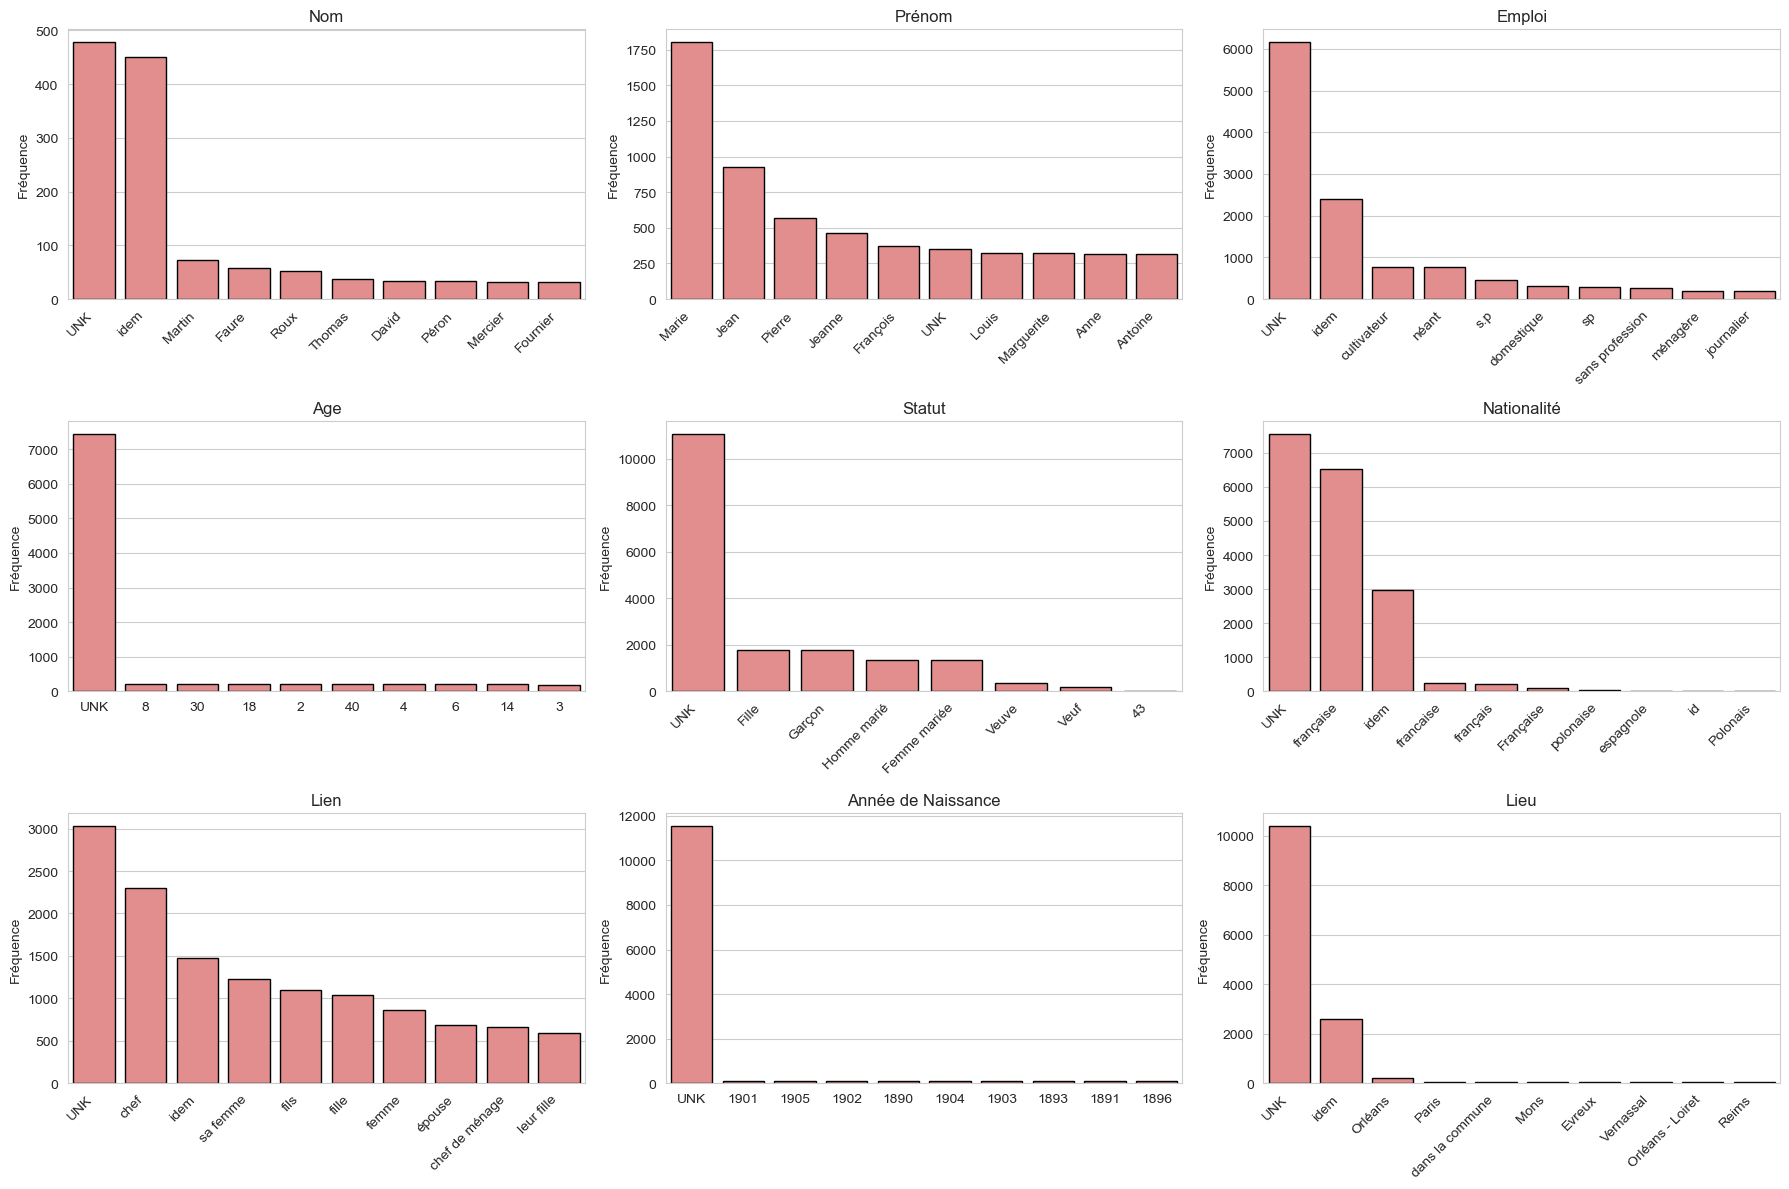

In [57]:
sns.set_style("whitegrid")
fig, axs = plt.subplots(3, 3, figsize=(18, 12))

variables = ['surname', 'firstname', 'occupation', 'age', 'civil_status', 'nationality', 'link', 'birth_date', 'lob']
clean_names = ['Nom', 'Prénom', 'Emploi', 'Age', 'Statut', 'Nationalité', 'Lien', 'Année de Naissance', 'Lieu']

for i, variable in enumerate(variables):
    counts = train_df[variable].value_counts().head(10)
    counts_df = pd.DataFrame({clean_names[i]: counts.index, 'Fréquence': counts.values})
    
    ax = sns.barplot(ax=axs[i//3, i%3], x=clean_names[i], y='Fréquence', data=counts_df, color='lightcoral', edgecolor='black')
    ax.set_xlabel('')
    ax.set_title(clean_names[i])
    
    if variable not in ['age', 'birth_date']:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [9]:
train_df_link_known = train_df[train_df["link"]!='UNK']
train_df_link_unknown = train_df[train_df["link"]=='UNK']

print("Percentage link known: {}".format(len(train_df_link_known)/len(train_df)))
print("Percentage link unknown: {}".format(len(train_df_link_unknown)/len(train_df)))

Percentage link known: 0.8298661868885641
Percentage link unknown: 0.17013381311143597


# Link Known

In [10]:
train_df_link_known_1 = train_df_link_known[train_df_link_known["y"] == 1]
train_df_link_known_0 = train_df_link_known[train_df_link_known["y"] == 0]

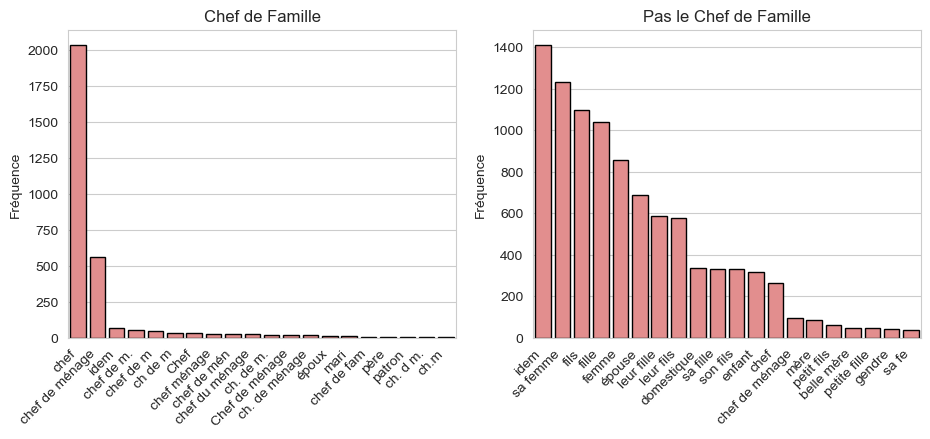

In [61]:
sns.set_style("whitegrid")
fig, axs = plt.subplots(1, 2, figsize=(11, 4))

counts0 = train_df_link_known_0["link"].value_counts().head(20)
counts1 = train_df_link_known_1["link"].value_counts().head(20)

counts_df0 = pd.DataFrame({"Lien": counts0.index, 'Fréquence': counts0.values})
counts_df1 = pd.DataFrame({"Lien": counts1.index, 'Fréquence': counts1.values})

ax = sns.barplot(ax=axs[0], x="Lien", y='Fréquence', data=counts_df1, color='lightcoral', edgecolor='black')
ax.set_xlabel('')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_title("Chef de Famille")

ax = sns.barplot(ax=axs[1], x="Lien", y='Fréquence', data=counts_df0, color='lightcoral', edgecolor='black')
ax.set_xlabel('')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_title("Pas le Chef de Famille")
plt.show()

# Link Unknown

## Age

In [13]:
def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    return ''.join([c for c in nfkd_form if not unicodedata.combining(c)])

def remove_uppercase(input_str):
    return input_str.lower()

def remove_periods(input_str):
    return input_str.replace('.', '')

def remove_de_d_du(input_str):
    return re.sub(r'\b(de|d|du)\b', "", input_str)

def remove_spaces(input_str):
    return input_str.replace(' ', '')

def pipeline_remove(input_str):
    return remove_spaces(remove_periods(remove_de_d_du(remove_periods(remove_uppercase(remove_accents((input_str)))))))

def convert_string_age_to_float(str_age):
    #jour(s), #semaine(s), #semmaine(s), #mois, #an(s), #annee(s)
    str_age = remove_accents(remove_uppercase(remove_periods(remove_spaces(str_age))))
    try: #age='52'
        age = float(str_age)
    except:
        if bool(re.search(r'jour|jours', str_age)): #contient jour(s)
            str_age_without_jour = re.sub(r'jour(s)', '', str_age)

            if bool(re.search(r'etdemi', str_age)): #contient "etdemi"
                str_age_without_jour = re.sub(r'etdemi', '', str_age_without_jour)

            elif bool(re.search(r'demi', str_age)): #contient "demi"
                str_age_without_jour = re.sub(r'demi', '', str_age_without_jour)

            try:
                age = float(str_age_without_jour)/365
            except:
                age = np.nan

        elif bool(re.search(r'semaine|semaines', str_age)): #contient semaine(s)
            str_age_without_sem = re.sub(r'semaine(s)', '', str_age)

            if bool(re.search(r'etdemi', str_age)): #contient "etdemi"
                str_age_without_sem = re.sub(r'etdemi', '', str_age_without_sem)

            elif bool(re.search(r'demi', str_age)): #contient "demi"
                str_age_without_sem = re.sub(r'demi', '', str_age_without_sem)
            try:
                age = float(str_age_without_sem)/52.143
            except:
                age = np.nan

        elif bool(re.search(r'semmaine|semmainess', str_age)): #contient semmaine(s)
            str_age_without_sem = re.sub(r'semmaine(s)', '', str_age)

            if bool(re.search(r'etdemi', str_age)): #contient "etdemi"
                str_age_without_sem = re.sub(r'etdemi', '', str_age_without_sem)

            elif bool(re.search(r'demi', str_age)): #contient "demi"
                str_age_without_sem = re.sub(r'demi', '', str_age_without_sem)
            try:
                age = float(str_age_without_sem)/52.143
            except:
                age = np.nan

        elif bool(re.search(r'mois', str_age)): #contient mois
            str_age_without_mois= re.sub(r'mois', '', str_age)

            if bool(re.search(r'etdemi', str_age)): #contient "etdemi"
                str_age_without_mois = re.sub(r'etdemi', '', str_age_without_mois)
                try:
                    age = float(str_age_without_mois)/12 + 1/24
                except:
                    age = np.nan

            elif bool(re.search(r'demi', str_age)): #contient "demi"
                str_age_without_mois = re.sub(r'demi', '', str_age_without_mois)
                try:
                    age = float(str_age_without_mois)/12 + 1/24
                except:
                    age = np.nan
            else:
                try:
                    age = float(str_age_without_mois)/12
                except:
                    age = np.nan
        
        elif bool(re.search(r'an|an(s)', str_age)): #contient an(s)
            str_age_without_ans= re.sub(r'an(s)', '', str_age)

            if bool(re.search(r'etdemi', str_age)): #contient "etdemi"
                str_age_without_ans = re.sub(r'etdemi', '', str_age_without_ans)
                try:
                    age = float(str_age_without_ans) + 0.5
                except:
                    age = np.nan

            elif bool(re.search(r'demi', str_age)): #contient "demi"
                str_age_without_ans = re.sub(r'demi', '', str_age_without_ans)
                try:
                    age = float(str_age_without_ans)
                except:
                    age = np.nan
            else:
                try:
                    age = float(str_age_without_ans)
                except:
                    age = np.nan

        elif bool(re.search(r'annee|annees', str_age)): #contient annee(s)
            str_age_without_ans= re.sub(r'annee(s)', '', str_age)

            if bool(re.search(r'etdemi', str_age)): #contient "etdemi"
                str_age_without_ans = re.sub(r'etdemi', '', str_age_without_ans)
                try:
                    age = float(str_age_without_ans) + 0.5
                except:
                    age = np.nan

            elif bool(re.search(r'demi', str_age)): #contient "demi"
                str_age_without_ans = re.sub(r'demi', '', str_age_without_ans)
                try:
                    age = float(str_age_without_ans)
                except:
                    age = np.nan
            else:
                try:
                    age = float(str_age_without_ans)
                except:
                    age = np.nan
        else:
            age = np.nan
    return age  

In [14]:
array_age_clean = np.array([convert_string_age_to_float(str_age) for str_age in train_df_link_unknown["age"]])
train_df_link_unknown["age_clean"] = array_age_clean

C:\Users\yanis\AppData\Local\Temp\ipykernel_104876\3121233149.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_link_unknown["age_clean"] = array_age_clean


## Birth Date

In [16]:
def convert_string_birth_date_to_int(str_birth_date):
    try:
        birth_date = int(str_birth_date)
        if (birth_date>=1700)&(birth_date<=1936):
            return birth_date
        else:
            return np.nan
    except:
        return np.nan

In [17]:
clean_birth = np.array([convert_string_birth_date_to_int(str_birth_date) for str_birth_date in train_df_link_unknown["birth_date"]])
train_df_link_unknown["clean_birth_date"] = clean_birth

C:\Users\yanis\AppData\Local\Temp\ipykernel_104876\971629168.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_link_unknown["clean_birth_date"] = clean_birth


C:\Users\yanis\AppData\Local\Temp\ipykernel_104876\2149372097.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(train_df_link_unknown[train_df_link_unknown["y"]==1]['age_clean'], label = "Chef de famille", ax=axs[0])
C:\Users\yanis\AppData\Local\Temp\ipykernel_104876\2149372097.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147

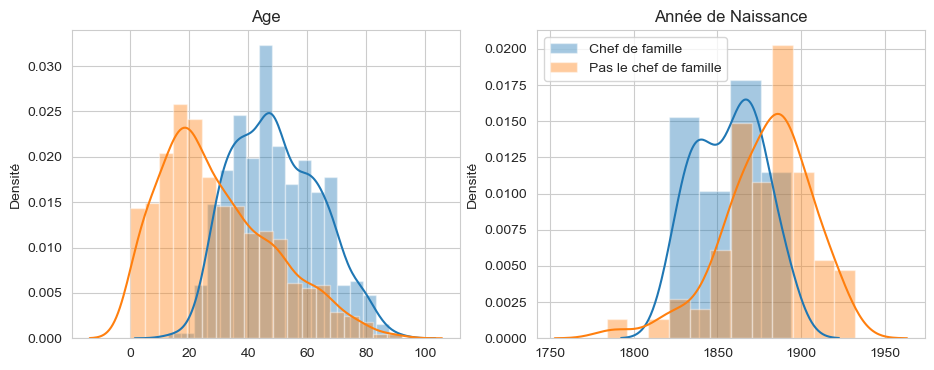

In [60]:
sns.set_style("whitegrid")
fig, axs = plt.subplots(1, 2, figsize=(11, 4))

ax = sns.distplot(train_df_link_unknown[train_df_link_unknown["y"]==1]['age_clean'], label = "Chef de famille", ax=axs[0])
ax = sns.distplot(train_df_link_unknown[train_df_link_unknown["y"]==0]['age_clean'], label = "Pas le chef de famille", ax=axs[0])
ax.set_title("Age")
ax.set_ylabel("Densité")
ax.set_xlabel('')

ax = sns.distplot(train_df_link_unknown[train_df_link_unknown["y"]==1]['clean_birth_date'], label = "Chef de famille", ax=axs[1])
ax = sns.distplot(train_df_link_unknown[train_df_link_unknown["y"]==0]['clean_birth_date'], label = "Pas le chef de famille", ax=axs[1])
ax.set_title("Année de Naissance")
ax.set_ylabel("Densité")
ax.set_xlabel('')
plt.legend()
plt.show()

In [42]:
corr_birth_y = train_df_link_unknown["clean_birth_date"].corr(train_df_link_unknown["y"])
corr_age_y = train_df_link_unknown["age_clean"].corr(train_df_link_unknown["y"])

print("Pearson's correlation - Birth Date x Target : {}".format(corr_birth_y))
print("Pearson's correlation - Age x Target : {}".format(corr_age_y))

Pearson's correlation - Birth Date x Target : -0.3673674668102775
Pearson's correlation - Age x Target : 0.4951498842199408


## Nationality

In [44]:
EU_pays = {
    "allemagne": "allemand",
    "autriche": "autrichien",
    "belgique": "belge",
    "bulgarie": "bulgare",
    "chypre": "chypriote",
    "croatie": "croate",
    "danemark": "danois",
    "espagne": "espagnol",
    "estonie": "estonien",
    "finlande": "finlandais",
    "france": "francais",
    "grece": "grec",
    "hongrie": "hongrois",
    "irlande": "irlandais",
    "italie": "italien",
    "lettonie": "letton",
    "lituanie": "lituanien",
    "luxembourg": "luxembourgeois",
    "malte": "maltais",
    "pays-bas": ["neerlandais", "hollandais"],
    "pologne": "polonais",
    "portugal": "portugais",
    "republique tcheque": "tcheque",
    "roumanie": "roumain",
    "slovaquie": "slovaque",
    "slovenie": "slovene",
    "suede": "suedois",
    "royaume-uni": "anglais",
    "unk": "unk"
}

def find_nationality(token_nationality):
    for word in token_nationality:
        if word == 'unk':
            return np.nan
        else:
            for key, value in EU_pays.items():
                if isinstance(value, list):
                    for value_i in value:
                        if levenshtein_dist(word, key)<=2 or levenshtein_dist(word, value_i) <=2:
                            return key
                else:
                    if levenshtein_dist(word, key)<=2 or levenshtein_dist(word, value) <=2:
                        return key
    return "autre"        


stop_words = set(stopwords.words('french'))
nationalies = train_df_link_unknown["nationality"].values
nationality_token  = [nltk.word_tokenize(nat, language='french') for nat in nationalies]
clean_nationality_token = [[remove_uppercase(remove_accents(remove_periods(word))) for word in token] for token in nationality_token]
clean_nationality_token_without_stop = [[w for w in token if not w in stop_words] for token in clean_nationality_token]
nationality_clean = [find_nationality(token) for token in clean_nationality_token_without_stop]
train_df_link_unknown["clean_nationality"] = nationality_clean

C:\Users\yanis\AppData\Local\Temp\ipykernel_104876\1761276521.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_link_unknown["clean_nationality"] = nationality_clean


In [56]:
vcramer_nat_y = cramers_corrected_stat(train_df_link_unknown["clean_nationality"], train_df_link_unknown["y"].apply(str))
vcramer_civil_y = cramers_corrected_stat(train_df_link_unknown["civil_status"], train_df_link_unknown["y"].apply(str))
v_cramer_lob_y = cramers_corrected_stat(train_df_link_unknown["lob"], train_df_link_unknown["y"].apply(str))
print("Cramer V - Nationality x Target : {}".format(vcramer_nat_y))
print("Cramer V - Civil Status x Target : {}".format(vcramer_civil_y))
print("Cramer V - Lob x Target : {}".format(v_cramer_lob_y))

Cramer V - Nationality x Target : 0.068076
Cramer V - Civil Status x Target : 0.663392
Cramer V - Lob x Target : 0.080245
